In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
from dotenv import load_dotenv
from pyproj import Transformer
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import folium
import cv2

In [23]:
load_dotenv()  # charge automatiquement le .env du dossier courant

True

In [24]:
list_bbox_centers = [(43.52960344286241, 5.448962145567533),
(48.092094070852475, -1.7036876101196967),
 (48.121222106840435, -1.602864906604979),
 (45.74557103359813, 4.803091960652229),
 (47.8776770361181, -3.909947991759771),
 (44.55378060775165, 4.28389205759154),
 (45.69764498502806, 5.8945655967385315),
 (48.07500134978729, 7.3491231648955155),
 (50.63412206750312, 3.0435779303880106),
 (44.83078182200822, 0.5108123933396876)]

In [25]:
from urban_watch.ml_logic.data import RAW_DATA_DIR
print(RAW_DATA_DIR)

/home/k2805/code/augustinlafond/project_urban_watch/raw_data


In [26]:
from urban_watch.ml_logic.data import make_bbox_global, get_data

data = get_data(list_bbox_centers)

📡 Downloading tile 0 at 43.52960344286241,5.448962145567533 ...
✔ Saved tile 0 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_0
📡 Downloading tile 1 at 48.092094070852475,-1.7036876101196967 ...
✔ Saved tile 1 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_1
📡 Downloading tile 2 at 48.121222106840435,-1.602864906604979 ...
✔ Saved tile 2 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_2
📡 Downloading tile 3 at 45.74557103359813,4.803091960652229 ...
✔ Saved tile 3 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_3
📡 Downloading tile 4 at 47.8776770361181,-3.909947991759771 ...
✔ Saved tile 4 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_4
📡 Downloading tile 5 at 44.55378060775165,4.28389205759154 ...
✔ Saved tile 5 in /home/k2805/code/augustinlafond/project_urban_watch/raw_data/tile_5
📡 Downloading tile 6 at 45.69764498502806,5.8945655967385315 ...
✔ Saved tile 6 in /home/k2805/c

In [27]:
from urban_watch.ml_logic.data import load_data
from s2cloudless import S2PixelCloudDetector
from urban_watch.ml_logic.package import CloudMasker
X, meta = load_data()

In [62]:
masker = CloudMasker(threshold=0.4)
img = X[1]
img

array([[[205, 205, 201, ..., 202,  87,  63],
        [205, 204, 200, ..., 204,  94,  70],
        [205, 206, 202, ..., 204,  94,  70],
        ...,
        [190, 199, 195, ..., 192, 107,  80],
        [190, 198, 196, ..., 192, 107,  80],
        [188, 197, 194, ..., 191, 102,  79]],

       [[205, 206, 200, ..., 203,  91,  64],
        [205, 207, 201, ..., 205,  98,  71],
        [205, 205, 203, ..., 205,  98,  71],
        ...,
        [193, 197, 197, ..., 192, 105,  80],
        [193, 197, 196, ..., 192, 105,  80],
        [190, 196, 194, ..., 190,  99,  76]],

       [[205, 207, 202, ..., 203,  91,  64],
        [205, 208, 203, ..., 205,  98,  71],
        [205, 207, 205, ..., 205,  98,  71],
        ...,
        [193, 197, 197, ..., 192, 105,  80],
        [193, 196, 196, ..., 192, 105,  80],
        [190, 195, 194, ..., 190,  99,  76]],

       ...,

       [[190, 192, 192, ..., 193,  91,  63],
        [190, 193, 192, ..., 194,  94,  65],
        [190, 193, 192, ..., 194,  94,  65

In [63]:
X.shape

(10, 300, 300, 10)

In [64]:
img.shape

(300, 300, 10)

In [65]:
mask=masker.detect_clouds(img)

In [66]:
cloud_masker = CloudMasker(threshold=0.4)
cloud_pct = cloud_masker.get_cloud_percentage(mask)
print(f"Pourcentage de nuages détectés : {cloud_pct:.2f}%")

Pourcentage de nuages détectés : 100.00%


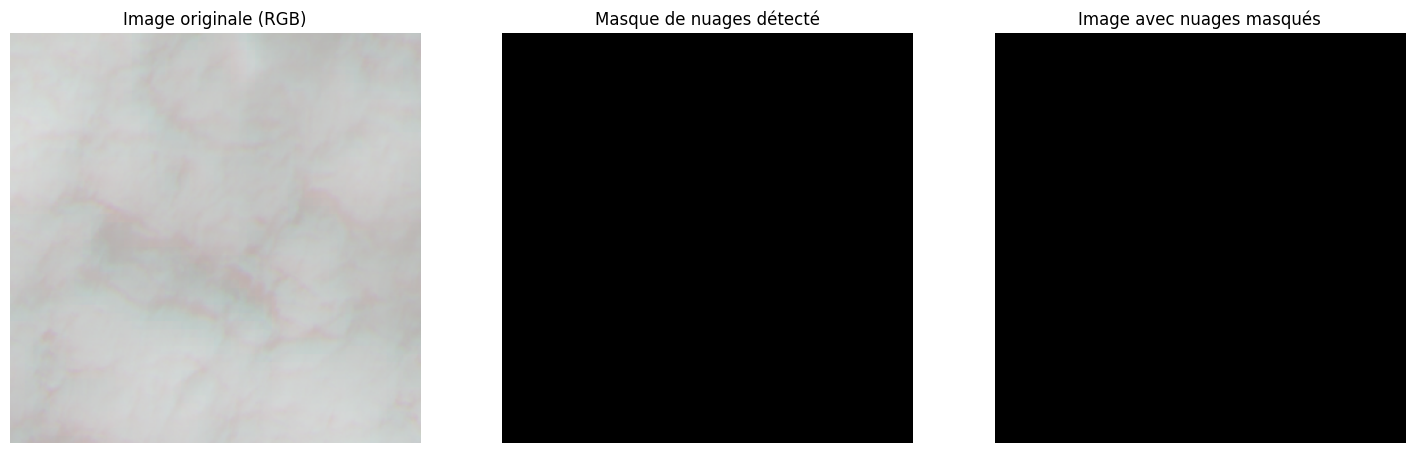

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Image RGB
axs[0].imshow(img[:, :, :3])
axs[0].set_title("Image originale (RGB)")
axs[0].axis("off")

# Masque de nuages
axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Masque de nuages détecté")
axs[1].axis("off")

# Image avec masque appliqué
img_masked = masker.apply_mask(img[:, :, :3], mask)
axs[2].imshow(img_masked)
axs[2].set_title("Image avec nuages masqués")
axs[2].axis("off")

plt.show()

In [53]:
from urban_watch.ml_logic.package import CloudMasker, ImageNormalizer
# Test 1 : Augmente le seuil
masker_high = CloudMasker(threshold=0.6, dilation_size=1)
mask_high = masker_high.detect_clouds(img)
print(f"Avec threshold=0.6 : {masker_high.get_cloud_percentage(mask_high):.2f}%")

# Test 2 : Normalise l'image avant
img_normalized = ImageNormalizer.normalize_full(img)
mask_normalized = masker.detect_clouds(img_normalized)
print(f"Avec normalisation : {masker.get_cloud_percentage(mask_normalized):.2f}%")

# Test 3 : Combiné (normalisé + seuil plus haut)
masker_combined = CloudMasker(threshold=0.6, dilation_size=1)
mask_combined = masker_combined.detect_clouds(img_normalized)
print(f"Avec normalisation + threshold=0.6 : {masker_combined.get_cloud_percentage(mask_combined):.2f}%")

# Affiche aussi la plage de valeurs
print(f"\nMin: {img.min()}, Max: {img.max()}")
print(f"Mean: {img.mean():.2f}, Std: {img.std():.2f}")

Avec threshold=0.6 : 80.02%
Avec normalisation : 7.51%
Avec normalisation + threshold=0.6 : 1.16%

Min: 0, Max: 137
Mean: 26.83, Std: 17.32


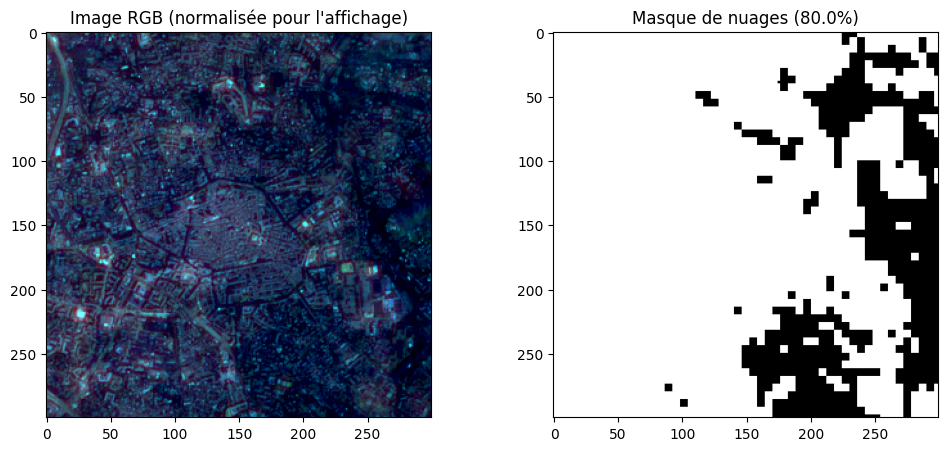

In [54]:
# Cloud detection sur données brutes
masker = CloudMasker(threshold=0.5, dilation_size=1)
mask = masker.detect_clouds(img)  # img en [0-137], pas normalisée

# Après, si tu veux visualiser, normalise pour l'affichage
img_for_display = ImageNormalizer.normalize_full(img)

# Puis affiche
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_for_display[:, :, :3])  # RGB normalisé
axes[0].set_title("Image RGB (normalisée pour l'affichage)")
axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f"Masque de nuages ({masker.get_cloud_percentage(mask):.1f}%)")
plt.show()

In [55]:
# Teste différents thresholds
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=1)
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh} → {pct:.1f}%")

threshold=0.3 → 91.3%
threshold=0.4 → 80.0%
threshold=0.5 → 80.0%
threshold=0.6 → 80.0%
threshold=0.7 → 80.0%


In [56]:
# Test sans dilation
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=0)
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh}, dilation=0 → {pct:.1f}%")

threshold=0.3, dilation=0 → 91.3%
threshold=0.4, dilation=0 → 80.0%
threshold=0.5, dilation=0 → 80.0%
threshold=0.6, dilation=0 → 80.0%
threshold=0.7, dilation=0 → 80.0%


In [57]:
# Test avec moins de lissage
for thresh in [0.3, 0.5, 0.7]:
    masker_test = CloudMasker(threshold=thresh, dilation_size=0)
    masker_test.detector.average_over = 1  # Réduis le lissage
    mask_test = masker_test.detect_clouds(img)
    pct = masker_test.get_cloud_percentage(mask_test)
    print(f"threshold={thresh}, dilation=0, average_over=1 → {pct:.1f}%")

threshold=0.3, dilation=0, average_over=1 → 91.3%
threshold=0.5, dilation=0, average_over=1 → 80.0%
threshold=0.7, dilation=0, average_over=1 → 80.0%


Min prob: 0.000, Max prob: 1.000
Mean prob: 0.842, Std prob: 0.321
Unique values: 24


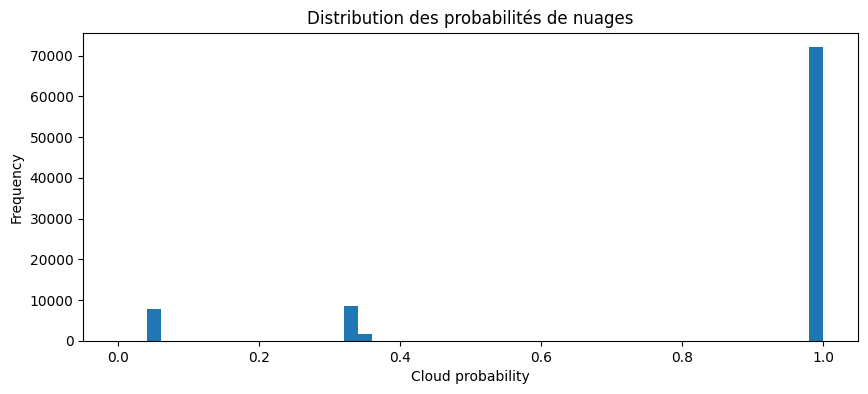

Percentile 10: 0.330
Percentile 25: 0.995
Percentile 50: 1.000
Percentile 75: 1.000
Percentile 90: 1.000
Percentile 95: 1.000


In [58]:
# Regarde la distribution réelle des probabilités
masker_debug = CloudMasker(threshold=0.0, dilation_size=0)
cloud_probs = masker_debug.detector.get_cloud_probability_maps(img[np.newaxis, :, :, :])
probs = cloud_probs[0].flatten()

print(f"Min prob: {probs.min():.3f}, Max prob: {probs.max():.3f}")
print(f"Mean prob: {probs.mean():.3f}, Std prob: {probs.std():.3f}")
print(f"Unique values: {len(np.unique(probs))}")

# Affiche l'histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(probs, bins=50)
plt.xlabel("Cloud probability")
plt.ylabel("Frequency")
plt.title("Distribution des probabilités de nuages")
plt.show()

# Vérifie les percentiles
for p in [10, 25, 50, 75, 90, 95]:
    print(f"Percentile {p}: {np.percentile(probs, p):.3f}")

In [59]:
masker = CloudMasker(threshold=0.99, dilation_size=0)
mask = masker.detect_clouds(img)
# Seuls les pixels absolument certains d'être nuages
for i in range(len(X)):
       img_i = X[i]
       masker = CloudMasker(threshold=0.5, dilation_size=0)
       mask = masker.detect_clouds(img_i)
       print(f"Tuile {i}: {masker.get_cloud_percentage(mask):.1f}%")

Tuile 0: 80.0%
Tuile 1: 100.0%
Tuile 2: 100.0%
Tuile 3: 100.0%
Tuile 4: 100.0%
Tuile 5: 100.0%
Tuile 6: 100.0%
Tuile 7: 100.0%
Tuile 8: 100.0%
Tuile 9: 100.0%


{'lat': 43.52960344286241, 'lon': 5.448962145567533, 'bbox': [696391.1284634634, 4821042.763172116, 699391.1284634634, 4824042.763172116], 'bbox_crs': 'EPSG:32631', 'bands': ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12'], 'resolution': 10}


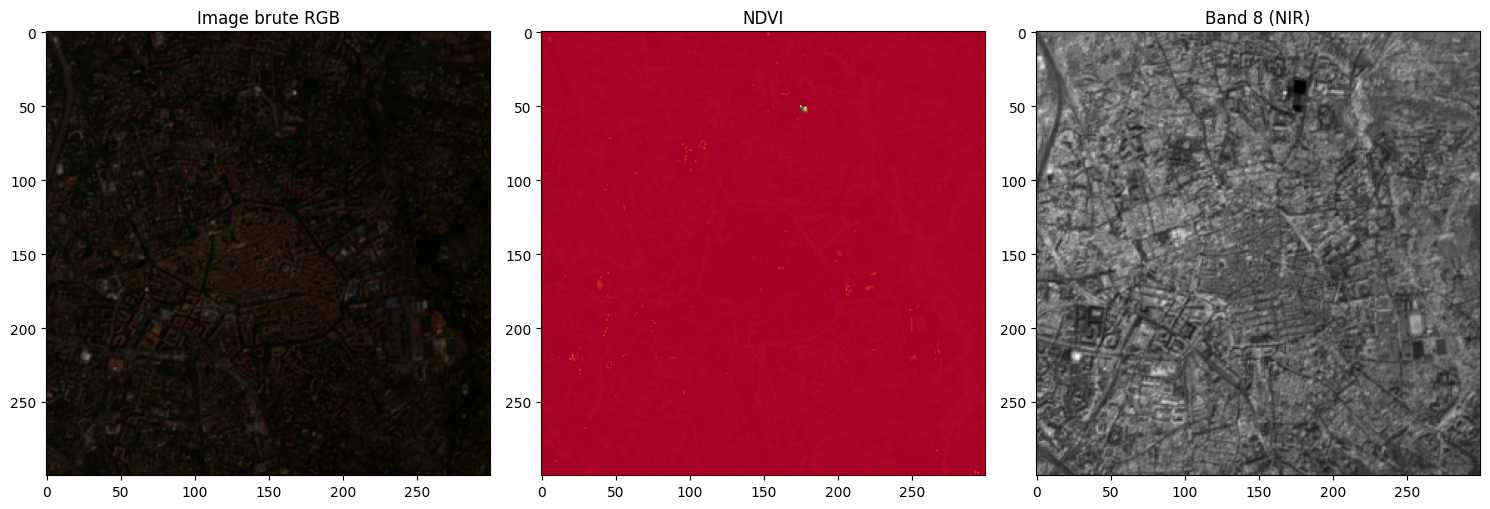

In [60]:
# 1. Affiche les métadonnées
print(meta[0])

# 2. Regarde l'image brute (avant cloud detection)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB brut
axes[0].imshow(X[0][:,:,[3,2,1]])  # B04, B03, B02 = RGB
axes[0].set_title("Image brute RGB")

# NDVI (végétation)
B4 = X[0][:,:,3]
B8 = X[0][:,:,6]
ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
axes[1].imshow(ndvi, cmap='RdYlGn')
axes[1].set_title("NDVI")

# Near Infrared
axes[2].imshow(X[0][:,:,6], cmap='gray')
axes[2].set_title("Band 8 (NIR)")

plt.tight_layout()
plt.show()